# Figure 1: Comparative analysis of the motile properties of K401 and Kif3 motor proteins in the ActiveDROPS platform


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


First let's load our data and clean it up

In [2]:
df = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/102224-k401-kif3_titrations-RT/output_data/merged_expression_PIV.csv")

# Assuming df is your DataFrame
# Find rows where the condition contains an underscore
df = df[df['condition'].str.contains('_')]

# Extract motor protein type
df['motor'] = df['condition'].apply(lambda x: x.split('_')[0])

# Extract DNA concentration
df['DNA'] = df['condition'].apply(
    lambda x: float(x.split('-')[0].split('_')[1].replace('nM', '').replace('p', '.'))
)

# Add replicate column with default value 1
df['replicate'] = 1

# Find rows where the condition has a third entry when split by "_"
has_third_entry = df['condition'].apply(lambda x: len(x.split('_')) > 2)

# Parse replicate from third entry when split by "_"
df.loc[has_third_entry, 'replicate'] = df.loc[has_third_entry, 'condition'].apply(
    lambda x: int(x.split('_')[2].replace('-RT', ''))
)

# keep only the replicate 1
df = df[(df['replicate'] == 1)]

# Sort by DNA concentration (descending) and time
df = df.sort_values(['DNA', 'time (s)'], ascending=[False, True])

# drop NaNs
# df = df.dropna()

# rename the column 'protein Concentration_nM' to 'prot'
# df.rename(columns={'Protein Concentration_nM': 'prot'}, inplace=True)
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),motor,DNA,replicate
20928,K401_160nM-RT,Rep1,0,0.000000,0.000000,1.010540,0.128887,2.867341,3.440809e+09,NaN,...,-1.331503,0.000343,0.000000,1.329279e-18,1.329279e-18,0.000000,0.000000,K401,160.000,1
54960,Kif3_160nM_1-RT,Rep1,0,0.000000,0.000000,1.330619,0.048544,0.753796,9.045554e+08,NaN,...,83.329548,0.000443,0.000000,4.792553e-18,4.792553e-18,0.000000,0.000000,Kif3,160.000,1
54961,Kif3_160nM_1-RT,Rep1,8,0.133333,0.002222,1.104430,0.040292,0.625660,7.507917e+08,NaN,...,92.890679,0.000443,0.000006,4.943225e-18,9.735778e-18,0.133333,0.002222,Kif3,160.000,1
54962,Kif3_160nM_1-RT,Rep1,16,0.266667,0.004444,0.974167,0.035540,0.551866,6.622393e+08,NaN,...,85.242425,0.000443,0.000011,4.287948e-18,1.402373e-17,0.266667,0.004444,Kif3,160.000,1
54963,Kif3_160nM_1-RT,Rep1,24,0.400000,0.006667,0.713773,0.026040,0.404352,4.852230e+08,NaN,...,93.844330,0.000443,0.000016,4.372660e-18,1.839639e-17,0.400000,0.006667,Kif3,160.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,K401_0p625nM-RT,Rep1,156660,2611.000000,43.516667,35.150500,4.483187,99.737193,1.196846e+11,-5.275542e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
2612,K401_0p625nM-RT,Rep1,156720,2612.000000,43.533333,35.428160,4.518600,100.525034,1.206300e+11,-4.611945e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
2613,K401_0p625nM-RT,Rep1,156780,2613.000000,43.550000,35.390331,4.513776,100.417698,1.205012e+11,2.879553e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
2614,K401_0p625nM-RT,Rep1,156840,2614.000000,43.566667,32.656452,4.165089,92.660500,1.111926e+11,2.184017e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1


In [3]:
df.columns

Index(['condition', 'subcondition', 'time (s)', 'Time_min', 'Time_h',
       'Mean Intensity', 'Protein Concentration_ng_ul',
       'Protein Concentration_nM', 'Number of Protein Molecules',
       'Rate of Change of Protein Molecules per Second',
       'Translation Rate aa_s', 'Unnamed: 0', 'frame', 'x [m]_mean',
       'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean', 'data type [-]_mean',
       'vorticity [1/s]_mean', 'velocity magnitude [m/s]_mean',
       'divergence [1/s]_mean', 'dcev [1]_mean', 'shear [1/s]_mean',
       'strain [1/s]_mean', 'vector direction [degrees]_mean',
       'correlation length [m]_mean', 'distance [m]_mean', 'power [W]_mean',
       'work [J]_mean', 'time (min)', 'time (h)', 'motor', 'DNA', 'replicate'],
      dtype='object')

aa

aa

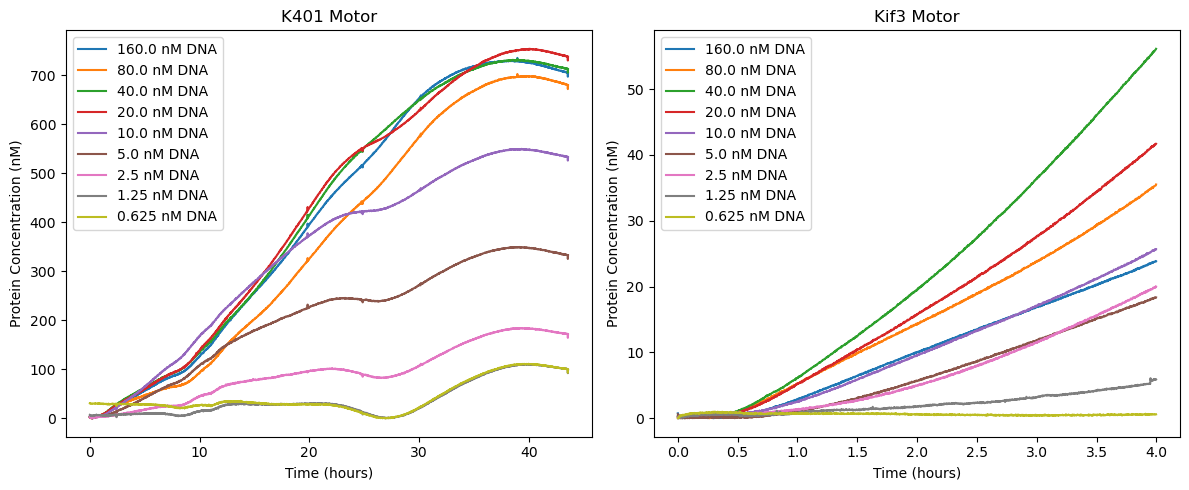

In [4]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
for dna_conc in k401_data['DNA'].unique():
    data = k401_data[k401_data['DNA'] == dna_conc]
    ax1.plot(data['Time_h'], data['Protein Concentration_nM'], 
             label=f'{dna_conc} nM DNA')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Protein Concentration (nM)')
ax1.set_title('K401 Motor')
ax1.legend()

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
for dna_conc in kif3_data['DNA'].unique():
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    ax2.plot(data['Time_h'], data['Protein Concentration_nM'],
             label=f'{dna_conc} nM DNA')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Protein Concentration (nM)')
ax2.set_title('Kif3 Motor')
ax2.legend()

plt.tight_layout()
plt.show()


Here it's becoming more clear that past 20nM DNA there is a saturation point,
and the increased activity we see in the drops is because of molecular crowding.
1 base pair is about 650 Daltons, so 1 linear DNA molecule of ~3000bp is about 2
kDa, which is more or less the weight of the PEG used in phases experiments.
This suggests repeating these experiments starting with 40nM DNA titrating down
to 1.25nM or so, but adding PEG to the lower titrations to see if we boost the
activity. 

Is the story different for the Kif3 motor? Well, there 

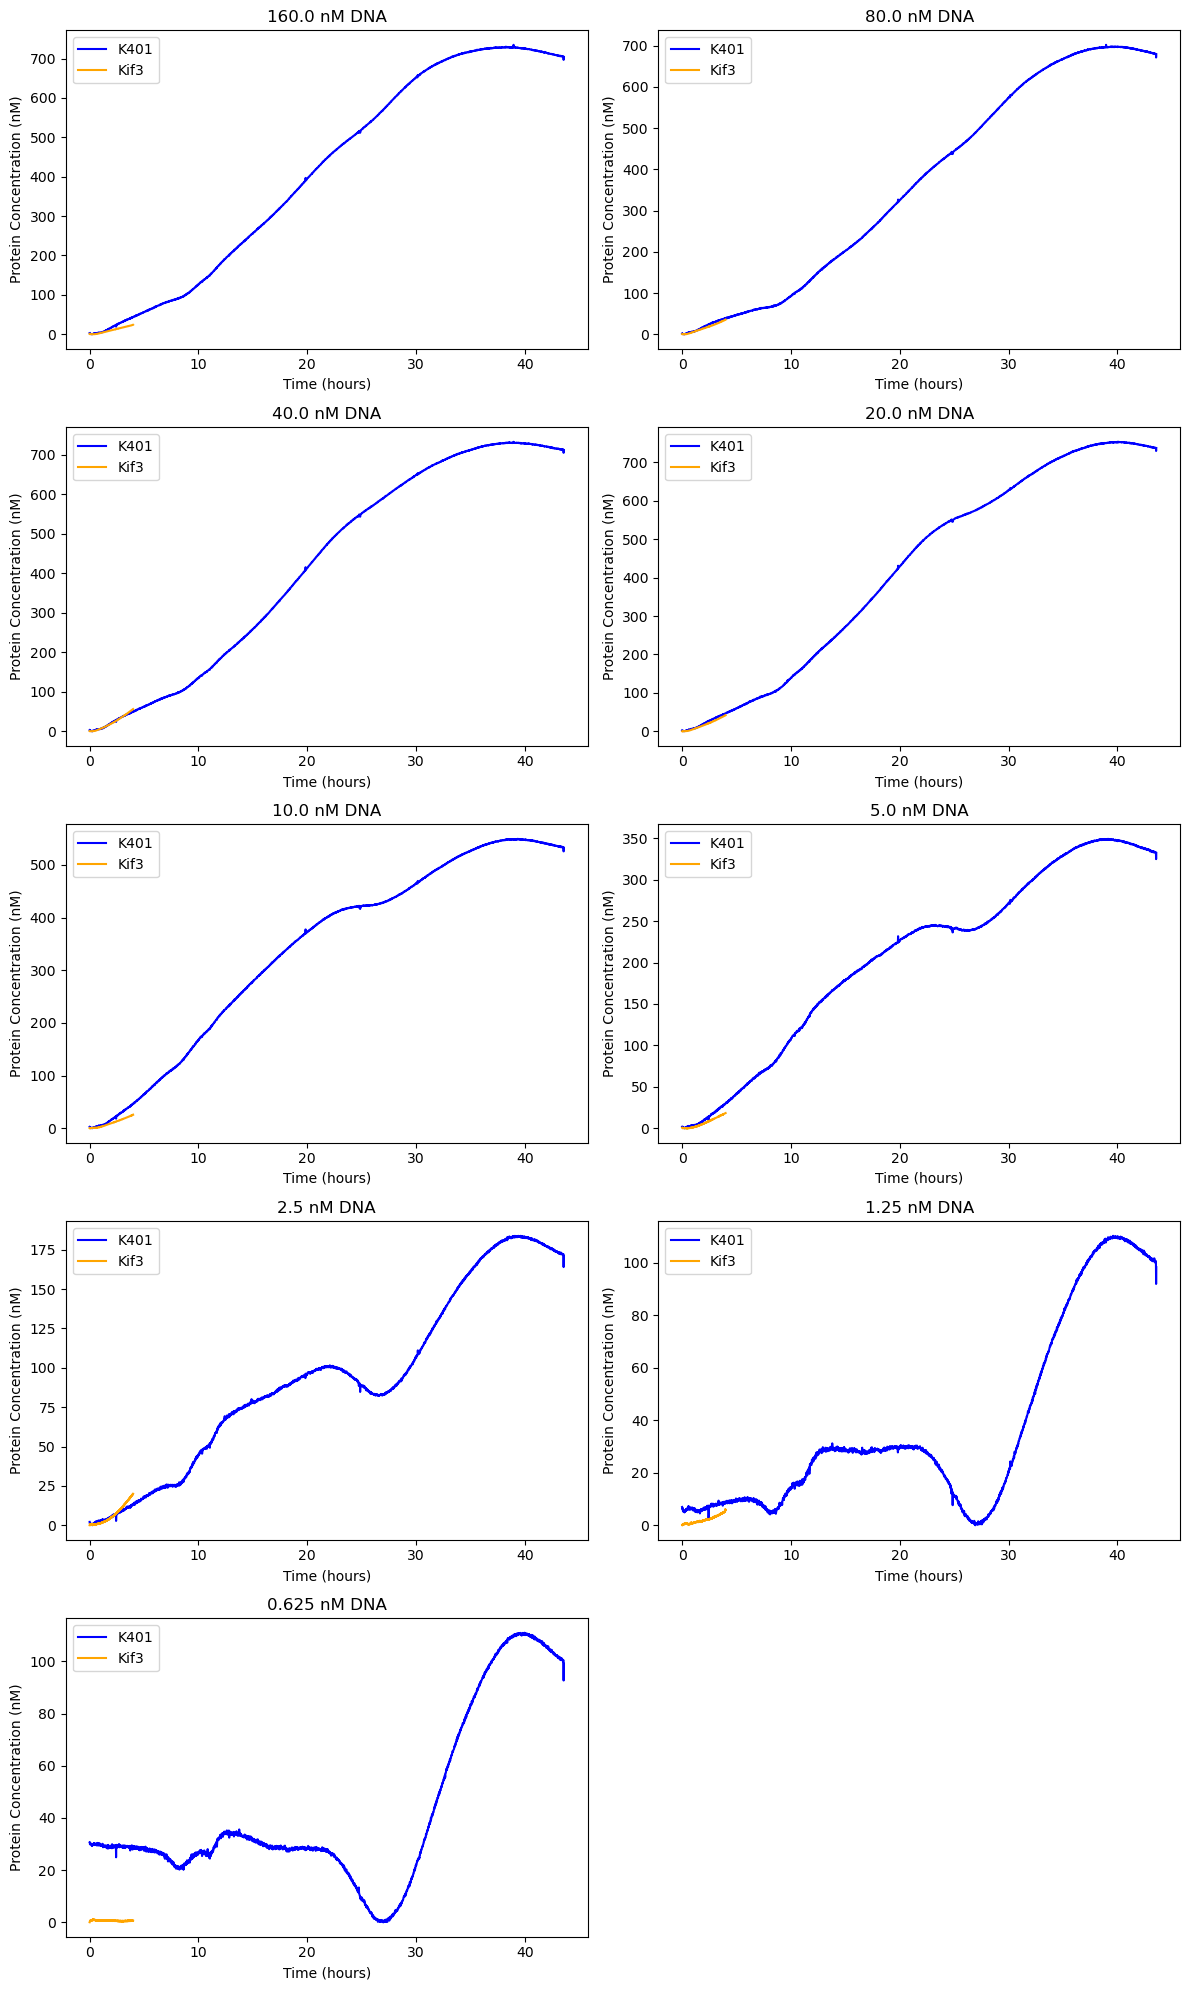

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique DNA concentrations in descending order
dna_concentrations = sorted(df['DNA'].unique(), reverse=True)

# Calculate number of rows needed (2 columns)
n_rows = int(np.ceil(len(dna_concentrations) / 2))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each DNA concentration
for idx, dna_conc in enumerate(dna_concentrations):
    # Get data for both motors at this DNA concentration
    k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc)]
    kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc)]
    
    # Plot both motors on same subplot
    axes[idx].plot(k401_data['Time_h'], k401_data['Protein Concentration_nM'], 
                  label='K401', color='blue')
    axes[idx].plot(kif3_data['Time_h'], kif3_data['Protein Concentration_nM'],
                  label='Kif3', color='orange')
    
    axes[idx].set_xlabel('Time (hours)')
    axes[idx].set_ylabel('Protein Concentration (nM)')
    axes[idx].set_title(f'{dna_conc} nM DNA')
    axes[idx].legend()

# Remove any empty subplots
for idx in range(len(dna_concentrations), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


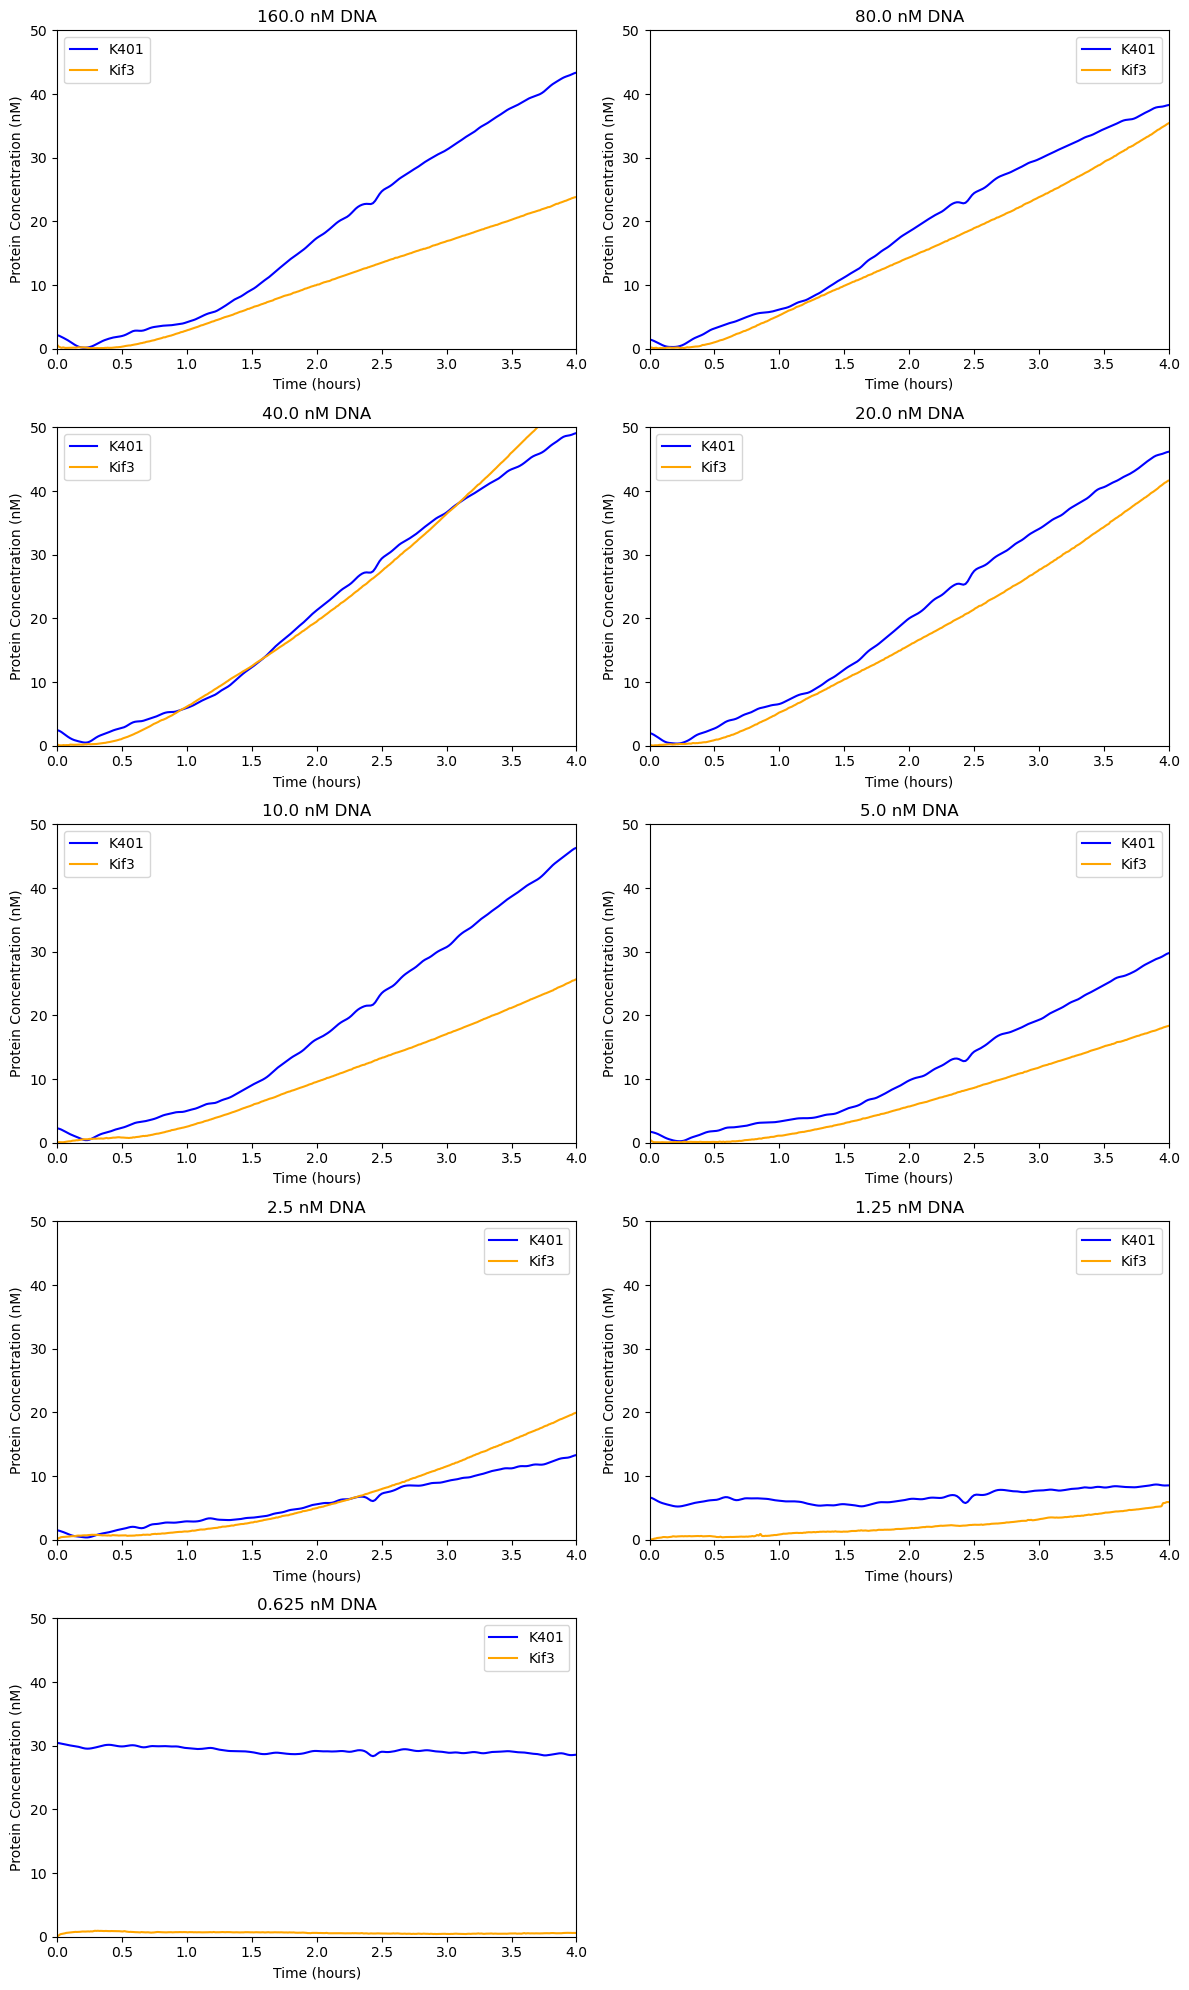

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Get unique DNA concentrations in descending order
dna_concentrations = sorted(df['DNA'].unique(), reverse=True)

# Calculate number of rows needed (2 columns)
n_rows = int(np.ceil(len(dna_concentrations) / 2))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each DNA concentration
for idx, dna_conc in enumerate(dna_concentrations):
    # Get data for both motors at this DNA concentration
    k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc) & (df['Time_h'] <= 4)]
    kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc) & (df['Time_h'] <= 4)]
    
    # Apply gaussian filter to the data
    k401_smooth = gaussian_filter1d(k401_data['Protein Concentration_nM'], sigma=2)
    kif3_smooth = gaussian_filter1d(kif3_data['Protein Concentration_nM'], sigma=2)
    
    # Plot both motors on same subplot
    axes[idx].plot(k401_data['Time_h'], k401_smooth, 
                  label='K401', color='blue')
    axes[idx].plot(kif3_data['Time_h'], kif3_smooth,
                  label='Kif3', color='orange')
    
    axes[idx].set_xlabel('Time (hours)')
    axes[idx].set_ylabel('Protein Concentration (nM)')
    axes[idx].set_title(f'{dna_conc} nM DNA')
    axes[idx].legend()
    axes[idx].set_xlim(0, 4)  # Set x-axis limit to 4 hours
    axes[idx].set_ylim(0, 50)  # Set y-axis limit from 0 to 40 nM

# Remove any empty subplots
for idx in range(len(dna_concentrations), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


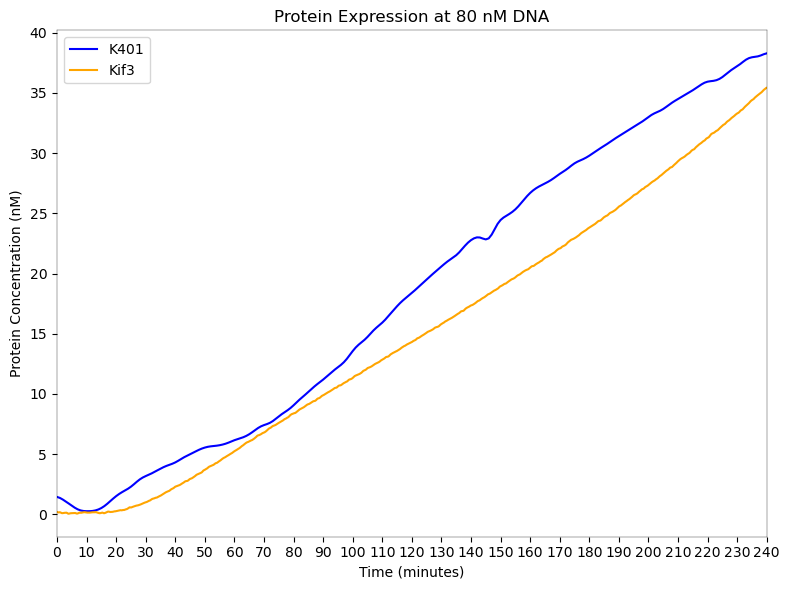

In [79]:
# Create figure
fig = plt.figure(figsize=(8, 6))

# Get data for both motors at 80nM DNA
k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == 80) & (df['Time_min'] <= 240)]
kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == 80) & (df['Time_min'] <= 240)]

# Apply gaussian filter to smooth the data
k401_smooth = gaussian_filter1d(k401_data['Protein Concentration_nM'], sigma=2)
kif3_smooth = gaussian_filter1d(kif3_data['Protein Concentration_nM'], sigma=2)

# Set spine thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.25)

# Plot both motors
plt.plot(k401_data['Time_min'], k401_smooth, label='K401', color='blue')
plt.plot(kif3_data['Time_min'], kif3_smooth, label='Kif3', color='orange')

plt.xlabel('Time (minutes)')
plt.ylabel('Protein Concentration (nM)')
plt.title('Protein Expression at 80 nM DNA')
plt.legend()
plt.xlim(0, 240)

# Set x-axis ticks every 10 minutes
plt.xticks(np.arange(0, 241, 10))

plt.tight_layout()
plt.savefig('Fig2_B.svg')
plt.show()


In [24]:
# Create figure with Bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# Get data for both motors at 80nM DNA
k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == 80) & (df['Time_h'] <= 14)]
kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == 80) & (df['Time_h'] <= 14)]

# Apply gaussian filter to smooth the data
k401_smooth = gaussian_filter1d(k401_data['Protein Concentration_nM'], sigma=2)
kif3_smooth = gaussian_filter1d(kif3_data['Protein Concentration_nM'], sigma=2)

# Create Bokeh figure with log y-axis
p = figure(width=800, height=600, 
          title='Protein Expression at 80 nM DNA',
          x_axis_label='Time (hours)', 
          y_axis_label='Protein Concentration (nM)',
          y_axis_type="log",
          tools='pan,box_zoom,wheel_zoom,reset,save')

# Plot both motors
p.line(k401_data['Time_h'], k401_smooth, line_color='blue', legend_label='K401', line_width=2)
p.line(kif3_data['Time_h'], kif3_smooth, line_color='orange', legend_label='Kif3', line_width=2)

# Style the plot
p.x_range.range_padding = 0
p.x_range.start = 0
p.x_range.end = 4
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_color = None

# Save and show the plot
p.output_backend = "svg"
show(p)


Loading BokehJS ...

The really weird thing is: if for example at 2.5nM DNA K401 and Kif3 have very
similar expression, why is it that there is no K401 activity past 20nM DNA?


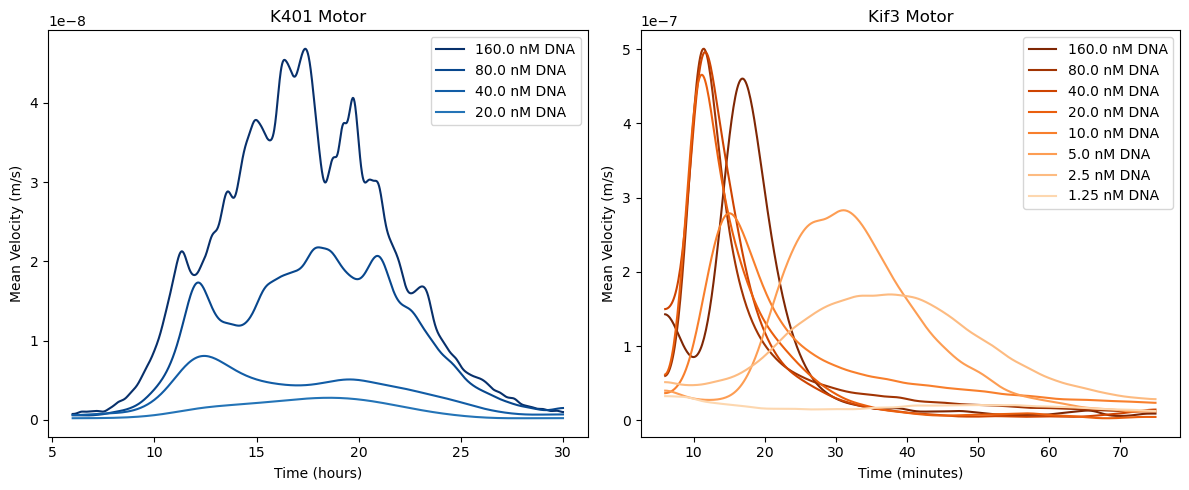

In [55]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
dna_concs = sorted(k401_data['DNA'].unique(), reverse=True)  # Reversed order
blues = plt.cm.Blues(np.linspace(1, 0.3, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = k401_data[k401_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    # Filter time range for K401
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax1.plot(data['Time_h'], y_smooth, label=f'{(dna_conc)} nM DNA', color=blues[i])
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mean Velocity (m/s)')
ax1.set_title('K401 Motor')
ax1.legend()
# make y axis log scale
# ax1.set_yscale('log')

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
dna_concs = sorted(kif3_data['DNA'].unique(), reverse=True)  # Reversed order
oranges = plt.cm.Oranges(np.linspace(1, 0.1, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    # Filter time range for Kif3 (convert hours to minutes)
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax2.plot(data['Time_min'], y_smooth, label=f'{(dna_conc)} nM DNA', color=oranges[i])
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Mean Velocity (m/s)')
ax2.set_title('Kif3 Motor')
ax2.legend()
# make y axis log scale
# ax2.set_yscale('log')

plt.tight_layout()
plt.show()


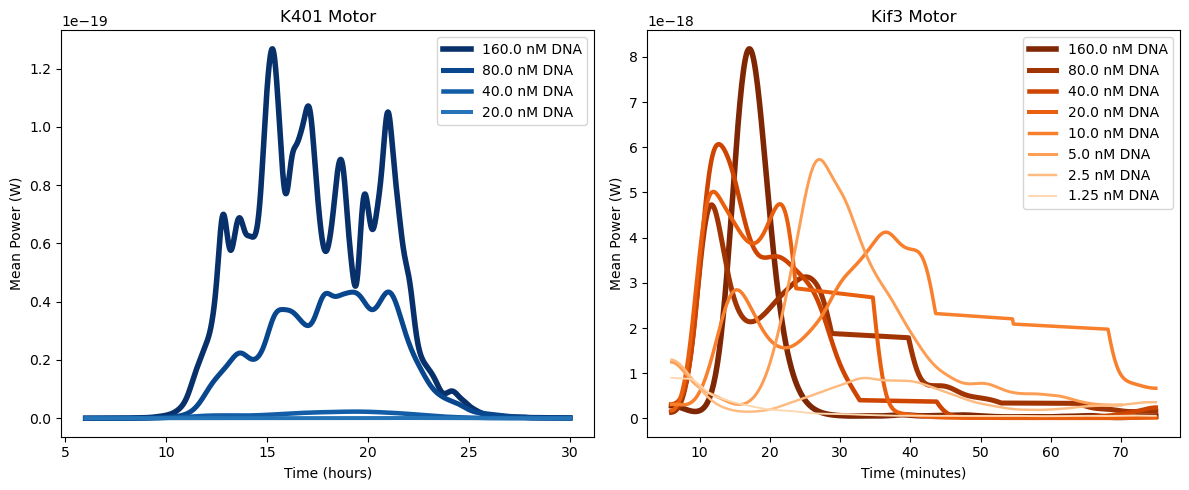

In [94]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
dna_concs = sorted(k401_data['DNA'].unique(), reverse=True)  # Reversed order
blues = plt.cm.Blues(np.linspace(1, 0.3, len(dna_concs)))
linewidths = np.linspace(4, 1, len(dna_concs))  # Line width gradient from thick to thin
for i, dna_conc in enumerate(dna_concs):
    data = k401_data[k401_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'power [W]_mean'])
    # Filter time range for K401
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['power [W]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax1.plot(data['Time_h'], y_smooth, label=f'{(dna_conc)} nM DNA', 
                color=blues[i], linewidth=linewidths[i])
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mean Power (W)')
ax1.set_title('K401 Motor')
ax1.legend()
# make y axis log scale
# ax1.set_yscale('log')

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
dna_concs = sorted(kif3_data['DNA'].unique(), reverse=True)[:]  # Reversed order
oranges = plt.cm.Oranges(np.linspace(1, 0.1, len(dna_concs)))
linewidths = np.linspace(4, 1, len(dna_concs))  # Line width gradient from thick to thin
for i, dna_conc in enumerate(dna_concs):
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'power [W]_mean'])
    # Filter time range for Kif3 (convert hours to minutes)
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['power [W]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax2.plot(data['Time_min'], y_smooth, label=f'{(dna_conc)} nM DNA',
                color=oranges[i], linewidth=linewidths[i])
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Mean Power (W)')
ax2.set_title('Kif3 Motor')
ax2.legend()
# make y axis log scale
# ax2.set_yscale('log')

plt.tight_layout()
plt.show()


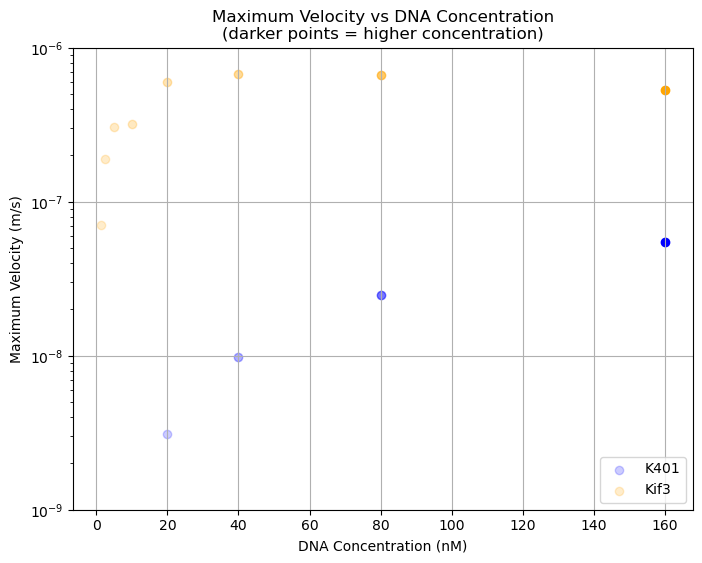

In [95]:
# Create figure
plt.figure(figsize=(8, 6))

# Process K401 data
k401_max_velocities = []
k401_concentrations = []
for dna_conc in sorted(df[df['motor'] == 'K401']['DNA'].unique()):
    data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc)]
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:
        k401_max_velocities.append(data['velocity magnitude [m/s]_mean'].max())
        k401_concentrations.append(dna_conc)

# Process Kif3 data
kif3_max_velocities = []
kif3_concentrations = []
for dna_conc in sorted(df[df['motor'] == 'Kif3']['DNA'].unique()):
    data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc)]
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    
    if len(data) > 0:
        # Find first minimum
        velocities = data['velocity magnitude [m/s]_mean'].values
        min_idx = None
        for i in range(1, len(velocities)-1):
            if velocities[i] < velocities[i-1] and velocities[i] < velocities[i+1]:
                min_idx = i
                break
                
        if min_idx is not None:
            # Only consider data after first minimum
            max_vel = velocities[min_idx:].max()
            kif3_max_velocities.append(max_vel)
            kif3_concentrations.append(dna_conc)

# Calculate alpha values based on concentration ranges
k401_alphas = [(c - min(k401_concentrations)) / (max(k401_concentrations) - min(k401_concentrations)) 
               for c in k401_concentrations]
kif3_alphas = [(c - min(kif3_concentrations)) / (max(kif3_concentrations) - min(kif3_concentrations))
               for c in kif3_concentrations]

# Plot data with alpha gradients
for i, (conc, vel, alpha) in enumerate(zip(k401_concentrations, k401_max_velocities, k401_alphas)):
    plt.scatter(conc, vel, color='blue', alpha=0.2 + 0.8*alpha, 
               label='K401' if i == 0 else "")
    
for i, (conc, vel, alpha) in enumerate(zip(kif3_concentrations, kif3_max_velocities, kif3_alphas)):
    plt.scatter(conc, vel, color='orange', alpha=0.2 + 0.8*alpha,
               label='Kif3' if i == 0 else "")

plt.yscale('log')
plt.ylim(1e-9, 1e-6)
plt.xlabel('DNA Concentration (nM)')
plt.ylabel('Maximum Velocity (m/s)')
plt.title('Maximum Velocity vs DNA Concentration\n(darker points = higher concentration)')
plt.legend()
plt.legend(loc='lower right')

plt.grid(True)
plt.show()


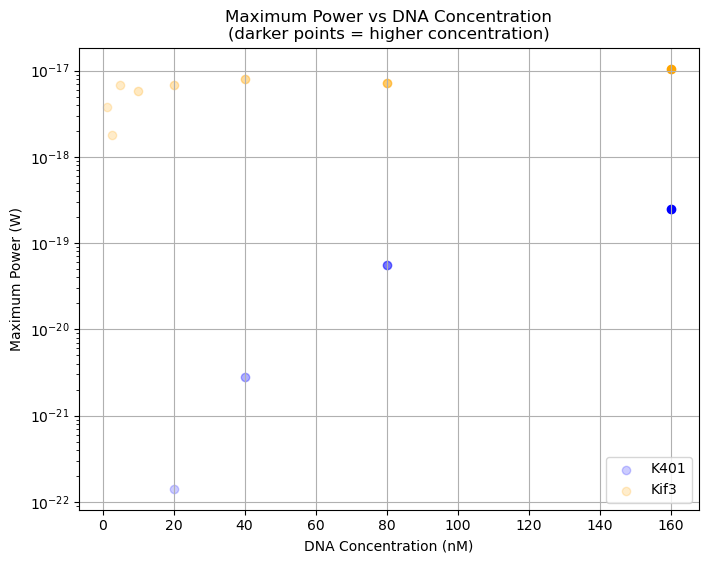

In [93]:
# Create figure
plt.figure(figsize=(8, 6))

# Process K401 data
k401_max_velocities = []
k401_concentrations = []
for dna_conc in sorted(df[df['motor'] == 'K401']['DNA'].unique()):
    data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc)]
    data = data.dropna(subset=['Time_h', 'power [W]_mean'])
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:
        k401_max_velocities.append(data['power [W]_mean'].max())
        k401_concentrations.append(dna_conc)

# Process Kif3 data
kif3_max_velocities = []
kif3_concentrations = []
for dna_conc in sorted(df[df['motor'] == 'Kif3']['DNA'].unique()):
    data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc)]
    data = data.dropna(subset=['Time_h', 'power [W]_mean'])
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    
    if len(data) > 0:
        # Find first minimum
        velocities = data['power [W]_mean'].values
        min_idx = None
        for i in range(1, len(velocities)-1):
            if velocities[i] < velocities[i-1] and velocities[i] < velocities[i+1]:
                min_idx = i
                break
                
        if min_idx is not None:
            # Only consider data after first minimum
            max_vel = velocities[min_idx:].max()
            kif3_max_velocities.append(max_vel)
            kif3_concentrations.append(dna_conc)

# Calculate alpha values based on concentration ranges
k401_alphas = [(c - min(k401_concentrations)) / (max(k401_concentrations) - min(k401_concentrations)) 
               for c in k401_concentrations]
kif3_alphas = [(c - min(kif3_concentrations)) / (max(kif3_concentrations) - min(kif3_concentrations))
               for c in kif3_concentrations]

# Plot data with alpha gradients
for i, (conc, vel, alpha) in enumerate(zip(k401_concentrations, k401_max_velocities, k401_alphas)):
    plt.scatter(conc, vel, color='blue', alpha=0.2 + 0.8*alpha, 
               label='K401' if i == 0 else "")
    
for i, (conc, vel, alpha) in enumerate(zip(kif3_concentrations, kif3_max_velocities, kif3_alphas)):
    plt.scatter(conc, vel, color='orange', alpha=0.2 + 0.8*alpha,
               label='Kif3' if i == 0 else "")

plt.yscale('log')
# plt.ylim(1e-18, 1e-15)
plt.xlabel('DNA Concentration (nM)')
plt.ylabel('Maximum Power (W)')
plt.title('Maximum Power vs DNA Concentration\n(darker points = higher concentration)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


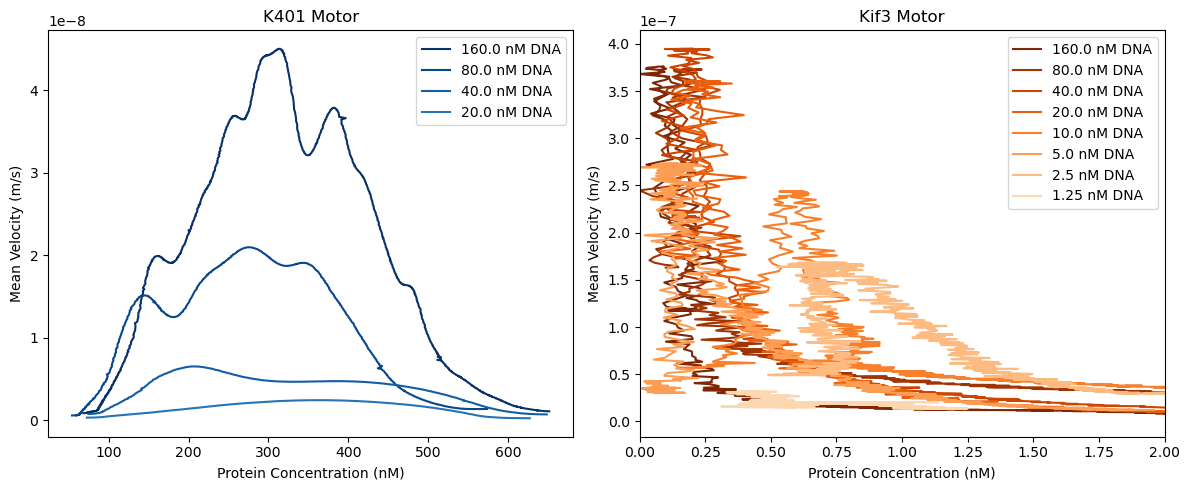

In [71]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
dna_concs = sorted(k401_data['DNA'].unique(), reverse=True)  # Reversed order
blues = plt.cm.Blues(np.linspace(1, 0.3, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = k401_data[k401_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
    # Filter time range for K401
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=20)
        ax1.plot(data['Protein Concentration_nM'], y_smooth, label=f'{(dna_conc)} nM DNA', color=blues[i])
ax1.set_xlabel('Protein Concentration (nM)')
ax1.set_ylabel('Mean Velocity (m/s)')
ax1.set_title('K401 Motor')
ax1.legend()
# make y axis log scale
# ax1.set_yscale('log')

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
dna_concs = sorted(kif3_data['DNA'].unique(), reverse=True)  # Reversed order
oranges = plt.cm.Oranges(np.linspace(1, 0.1, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
    # Filter time range for Kif3 (convert hours to minutes)
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=20)
        ax2.plot(data['Protein Concentration_nM'], y_smooth, label=f'{(dna_conc)} nM DNA', color=oranges[i])
ax2.set_xlabel('Protein Concentration (nM)')
ax2.set_ylabel('Mean Velocity (m/s)')
ax2.set_title('Kif3 Motor')
ax2.legend()
# make y axis log scale
# ax2.set_yscale('log')
ax2.set_xlim(0, 2)  # Set x-axis limits for Kif3 plot from 0 to 2 nM

plt.tight_layout()
plt.show()


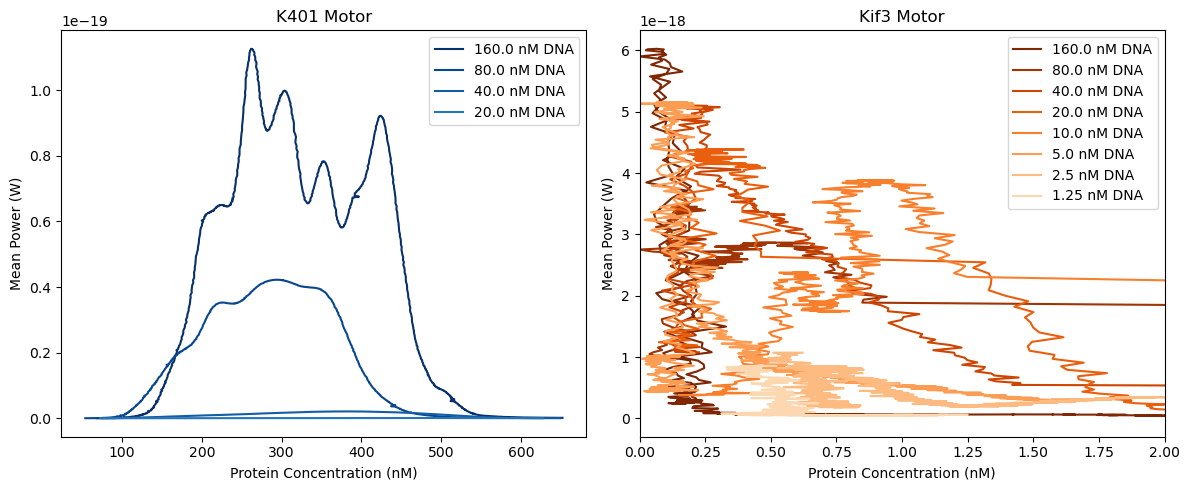

In [72]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
dna_concs = sorted(k401_data['DNA'].unique(), reverse=True)  # Reversed order
blues = plt.cm.Blues(np.linspace(1, 0.3, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = k401_data[k401_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'power [W]_mean', 'Protein Concentration_nM'])
    # Filter time range for K401
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['power [W]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=20)
        ax1.plot(data['Protein Concentration_nM'], y_smooth, label=f'{(dna_conc)} nM DNA', color=blues[i])
ax1.set_xlabel('Protein Concentration (nM)')
ax1.set_ylabel('Mean Power (W)')
ax1.set_title('K401 Motor')
ax1.legend()
# make y axis log scale
# ax1.set_yscale('log')

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
dna_concs = sorted(kif3_data['DNA'].unique(), reverse=True)  # Reversed order
oranges = plt.cm.Oranges(np.linspace(1, 0.1, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'power [W]_mean', 'Protein Concentration_nM'])
    # Filter time range for Kif3 (convert hours to minutes)
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['power [W]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=20)
        ax2.plot(data['Protein Concentration_nM'], y_smooth, label=f'{(dna_conc)} nM DNA', color=oranges[i])
ax2.set_xlabel('Protein Concentration (nM)')
ax2.set_ylabel('Mean Power (W)')
ax2.set_title('Kif3 Motor')
ax2.legend()
# make y axis log scale
# ax2.set_yscale('log')
ax2.set_xlim(0, 2)  # Set x-axis limits for Kif3 plot from 0 to 2 nM

plt.tight_layout()
plt.show()


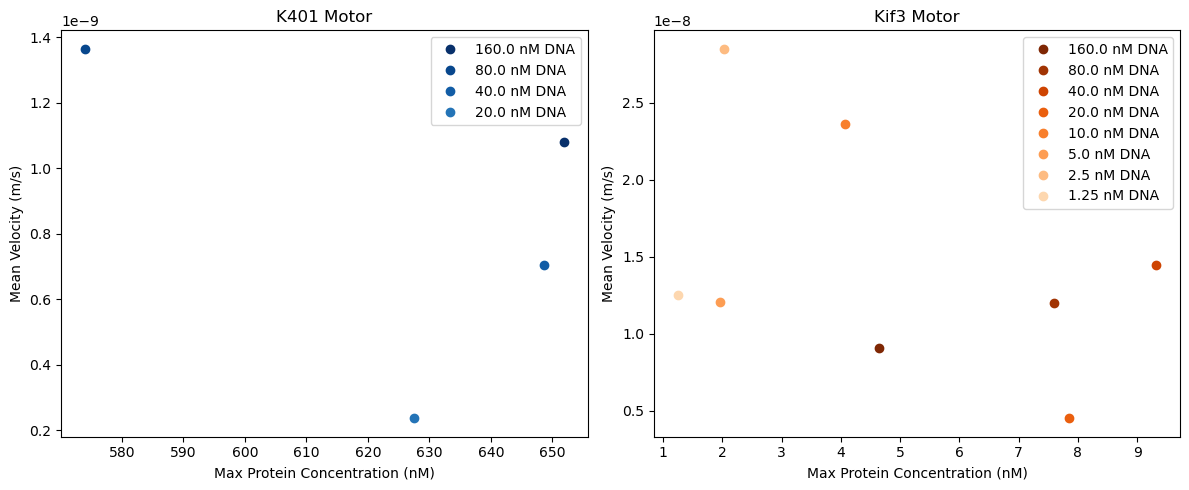

In [63]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot K401 data
k401_data = df[df['motor'] == 'K401']
dna_concs = sorted(k401_data['DNA'].unique(), reverse=True)  # Reversed order
blues = plt.cm.Blues(np.linspace(1, 0.3, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = k401_data[k401_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
    # Filter time range for K401
    data = data[(data['Time_h'] >= 6) & (data['Time_h'] <= 30)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=20)
        max_protein_conc = data['Protein Concentration_nM'].max()
        ax1.plot(max_protein_conc, y_smooth[-1], 'o', label=f'{(dna_conc)} nM DNA', color=blues[i])
ax1.set_xlabel('Max Protein Concentration (nM)')
ax1.set_ylabel('Mean Velocity (m/s)')
ax1.set_title('K401 Motor')
ax1.legend()
# make y axis log scale
# ax1.set_yscale('log')

# Plot Kif3 data
kif3_data = df[df['motor'] == 'Kif3']
dna_concs = sorted(kif3_data['DNA'].unique(), reverse=True)  # Reversed order
oranges = plt.cm.Oranges(np.linspace(1, 0.1, len(dna_concs)))
for i, dna_conc in enumerate(dna_concs):
    data = kif3_data[kif3_data['DNA'] == dna_conc]
    # Drop rows with NaN values before plotting
    data = data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
    # Filter time range for Kif3 (convert hours to minutes)
    data = data[(data['Time_min'] >= 6) & (data['Time_min'] <= 75)]
    if len(data) > 0:  # Only plot if there is valid data
        y_data = data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        max_protein_conc = data['Protein Concentration_nM'].max()
        ax2.plot(max_protein_conc, y_smooth[-1], 'o', label=f'{(dna_conc)} nM DNA', color=oranges[i])
ax2.set_xlabel('Max Protein Concentration (nM)')
ax2.set_ylabel('Mean Velocity (m/s)')
ax2.set_title('Kif3 Motor')
ax2.legend()
# make y axis log scale
# ax2.set_yscale('log')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


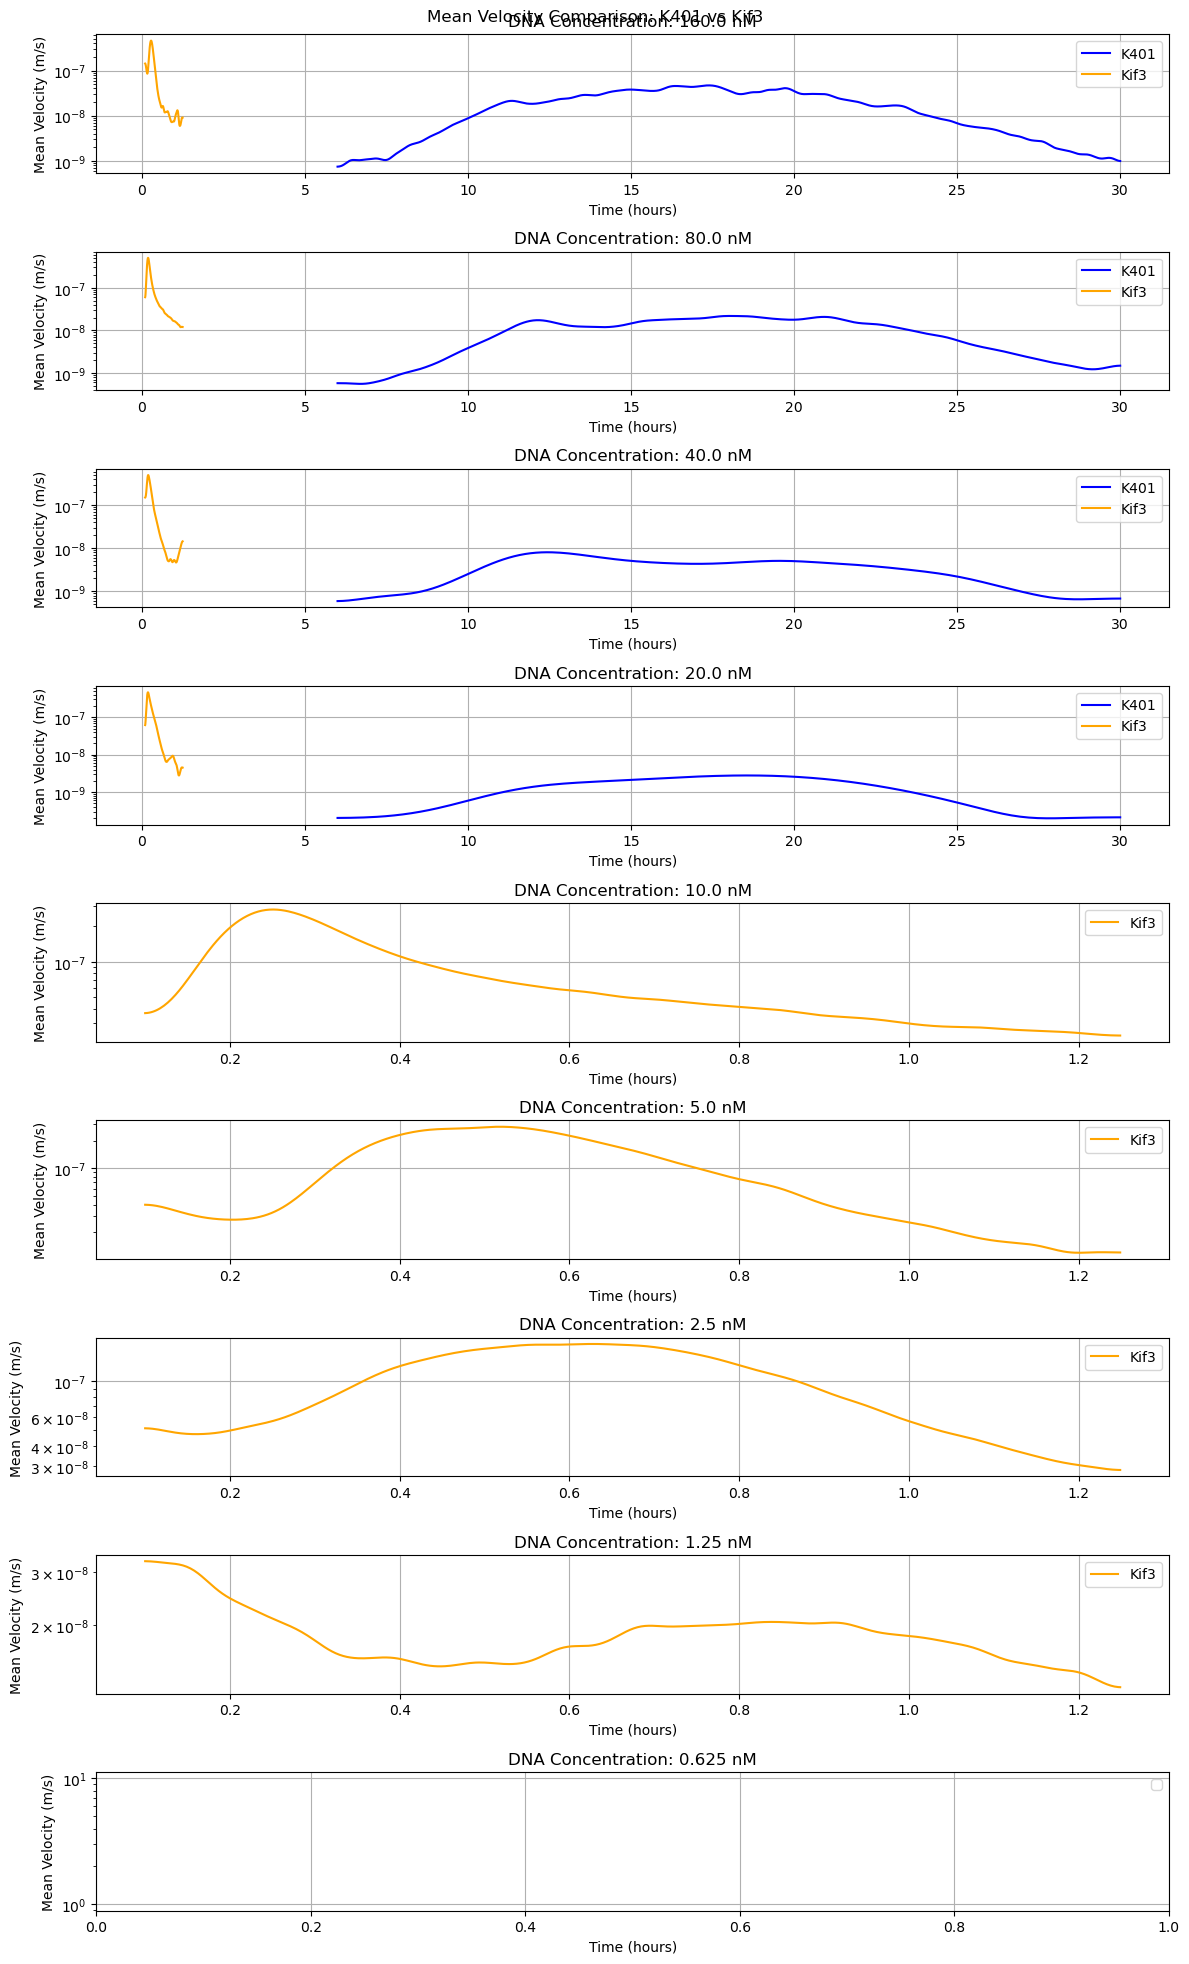

In [9]:
# Create figure with subplots
fig, axes = plt.subplots(len(df['DNA'].unique()), 1, figsize=(12, 20))
fig.suptitle('Mean Velocity Comparison: K401 vs Kif3')

# Process each DNA concentration
for idx, dna_conc in enumerate(sorted(df['DNA'].unique(), reverse=True)):
    ax = axes[idx]
    
    # Plot K401 data
    k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc)]
    k401_data = k401_data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    k401_data = k401_data[(k401_data['Time_h'] >= 6) & (k401_data['Time_h'] <= 30)]
    if len(k401_data) > 0:
        y_data = k401_data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax.plot(k401_data['Time_h'], y_smooth, label='K401', color='blue')
        
    # Plot Kif3 data
    kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc)]
    kif3_data = kif3_data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
    kif3_data = kif3_data[(kif3_data['Time_h'] >= 0.1) & (kif3_data['Time_h'] <= 1.25)]
    if len(kif3_data) > 0:
        y_data = kif3_data['velocity magnitude [m/s]_mean'].values
        y_smooth = gaussian_filter1d(y_data, sigma=10)
        ax.plot(kif3_data['Time_h'], y_smooth, label='Kif3', color='orange')
    
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Mean Velocity (m/s)')
    ax.set_title(f'DNA Concentration: {dna_conc} nM')
    ax.legend()
    ax.grid(True)
    ax.set_yscale('log')  # Set y-axis to log scale

plt.tight_layout()
plt.show()


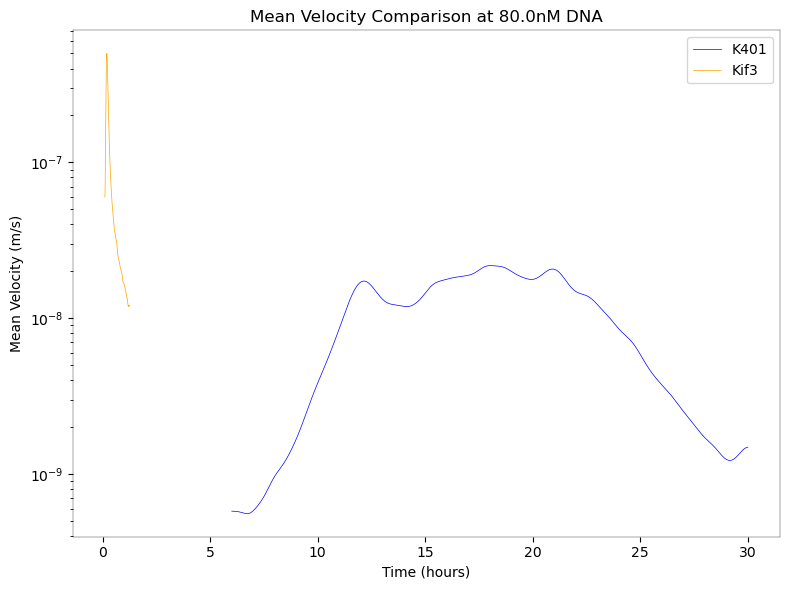

In [104]:
# Create figure
plt.figure(figsize=(8, 6))

# Get data for 80nM DNA concentration
dna_conc = 80.0

# Plot K401 data
k401_data = df[(df['motor'] == 'K401') & (df['DNA'] == dna_conc)]
k401_data = k401_data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
k401_data = k401_data[(k401_data['Time_h'] >= 6) & (k401_data['Time_h'] <= 30)]
if len(k401_data) > 0:
    y_data = k401_data['velocity magnitude [m/s]_mean'].values
    y_smooth = gaussian_filter1d(y_data, sigma=10)
    plt.plot(k401_data['Time_h'], y_smooth, label='K401', color='blue', linewidth=0.5)

# Plot Kif3 data  
kif3_data = df[(df['motor'] == 'Kif3') & (df['DNA'] == dna_conc)]
kif3_data = kif3_data.dropna(subset=['Time_h', 'velocity magnitude [m/s]_mean'])
kif3_data = kif3_data[(kif3_data['Time_h'] >= 0.1) & (kif3_data['Time_h'] <= 1.25)]
if len(kif3_data) > 0:
    y_data = kif3_data['velocity magnitude [m/s]_mean'].values
    y_smooth = gaussian_filter1d(y_data, sigma=10)
    plt.plot(kif3_data['Time_h'], y_smooth, label='Kif3', color='orange', linewidth=0.5)

plt.xlabel('Time (hours)')
plt.ylabel('Mean Velocity (m/s)') 
plt.title(f'Mean Velocity Comparison at {dna_conc}nM DNA')
plt.legend()
# plt.grid(True)
plt.yscale('log')

# Set spine width
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.25)

plt.tight_layout()
plt.savefig('Fig2_C.svg')
plt.show()


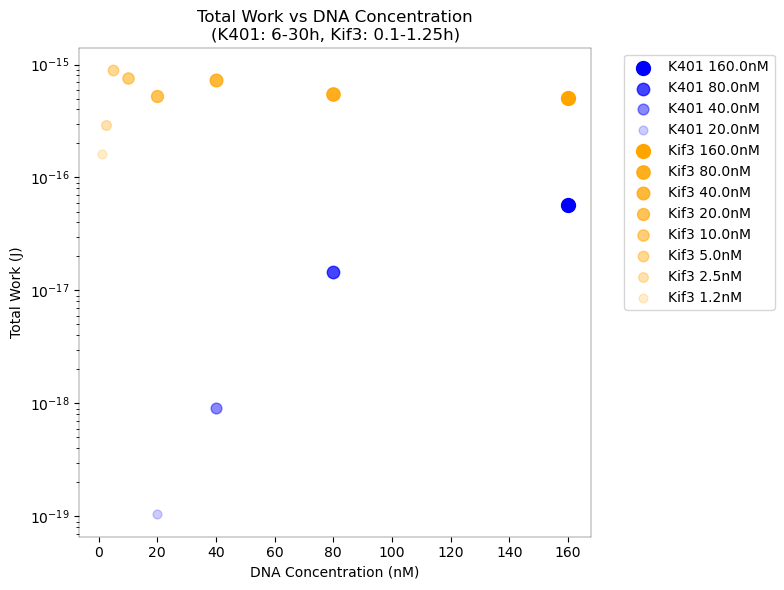

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(8, 6))

# Define colors for each motor
motor_colors = {'K401': 'blue', 'Kif3': 'orange'}

# Process data for each motor
for motor in ['K401', 'Kif3']:
    motor_data = df[df['motor'] == motor]
    
    # Apply time filter based on motor type
    if motor == 'K401':
        motor_data = motor_data[(motor_data['Time_h'] >= 6) & (motor_data['Time_h'] <= 30)]
    else:  # Kif3
        motor_data = motor_data[(motor_data['Time_h'] >= 0.1) & (motor_data['Time_h'] <= 1.25)]
    
    # Calculate mean total work for each DNA concentration
    # Use last non-NaN value for each concentration
    dna_concs = []
    total_works = []
    
    # Get DNA concentrations in descending order
    for dna_conc in sorted(motor_data['DNA'].unique(), reverse=True):
        data = motor_data[motor_data['DNA'] == dna_conc]
        work_data = data['work [J]_mean'].dropna()
        if len(work_data) > 0:
            dna_concs.append(dna_conc)
            total_works.append(work_data.iloc[-1])
    
    # Plot points with decreasing transparency and size
    alphas = np.linspace(1.0, 0.2, len(dna_concs))
    sizes = np.linspace(100, 40, len(dna_concs))  # Decreasing point sizes
    for i, (x, y, alpha, size) in enumerate(zip(dna_concs, total_works, alphas, sizes)):
        plt.scatter(x, y, color=motor_colors[motor], s=size, alpha=alpha,
                   label=f'{motor} {x:.1f}nM')

plt.xlabel('DNA Concentration (nM)')
plt.ylabel('Total Work (J)')
plt.title('Total Work vs DNA Concentration\n(K401: 6-30h, Kif3: 0.1-1.25h)')
plt.grid(False)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)

# Set spine thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.25)

plt.tight_layout()
plt.savefig('Fig2_D.svg')
plt.show()


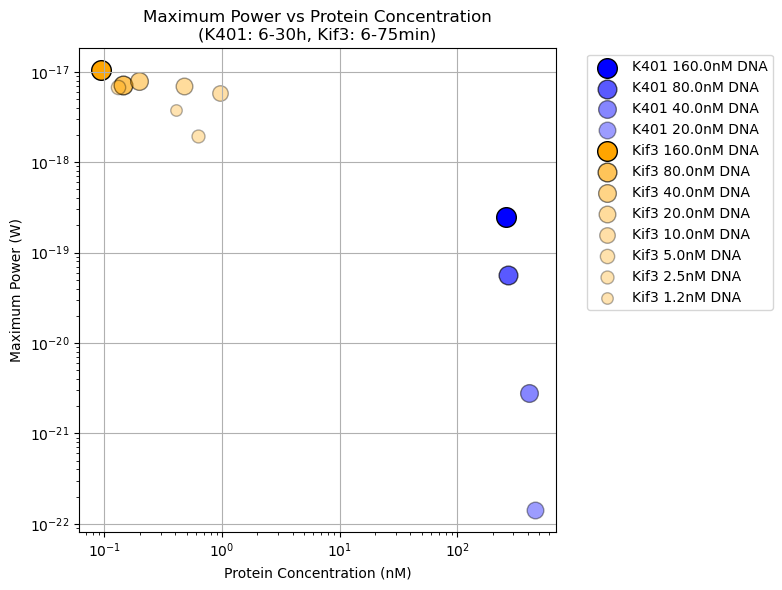

In [107]:
# Create figure
plt.figure(figsize=(8, 6))

# Define colors for each motor
motor_colors = {'K401': 'blue', 'Kif3': 'orange'}

# Process data for each motor
for motor in ['K401', 'Kif3']:
    motor_data = df[df['motor'] == motor]
    
    # Apply time filter based on motor type
    if motor == 'K401':
        motor_data = motor_data[(motor_data['Time_h'] >= 6) & (motor_data['Time_h'] <= 30)]
    else:  # Kif3
        motor_data = motor_data[(motor_data['Time_min'] >= 6) & (motor_data['Time_min'] <= 75)]
    
    # Get sorted DNA concentrations for size scaling
    dna_concs_sorted = sorted(motor_data['DNA'].unique(), reverse=True)
    sizes = np.linspace(200, 50, len(dna_concs_sorted))  # Larger size range
    
    # Create dict mapping DNA conc to size
    size_map = dict(zip(dna_concs_sorted, sizes))
    
    # Plot for each DNA concentration
    for dna_conc in dna_concs_sorted:
        data = motor_data[motor_data['DNA'] == dna_conc]
        
        # Get power and protein concentration data, dropping NaN values
        mask = ~data[['power [W]_mean', 'Protein Concentration_nM']].isna().any(axis=1)
        power_data = data[mask]['power [W]_mean']
        protein_data = data[mask]['Protein Concentration_nM']
        
        if len(power_data) > 0:
            # Find index of maximum power
            max_power_idx = power_data.idxmax()
            max_power = power_data[max_power_idx]
            max_power_protein = protein_data[max_power_idx]
            
            # Plot points with transparency and size based on DNA concentration
            alpha = 0.3 + 0.7 * (dna_conc / max(motor_data['DNA'].unique()))
            plt.scatter(max_power_protein, max_power,
                       color=motor_colors[motor],
                       alpha=alpha,
                       s=size_map[dna_conc],  # Size based on DNA concentration
                       label=f'{motor} {dna_conc:.1f}nM DNA',
                       edgecolor='black',
                       linewidth=1)

plt.xlabel('Protein Concentration (nM)')
plt.ylabel('Maximum Power (W)')
plt.title('Maximum Power vs Protein Concentration\n(K401: 6-30h, Kif3: 6-75min)')
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
